Deformable Face Model
----------------------------------

Compute the face keypoints arrays based on the full deformable face model from  https://github.com/cleardusk/3DDFA_V2/tree/master/configs

Take only 68 keypoints from the full triangulated mesh. Also take corresponding points from the deformation vectors

Scale and shift them a bit, and save them.

In [1]:
import numpy as np

In [2]:
from importlib import reload

In [3]:
from os.path import join, dirname
import sys
from copy import copy
import cv2
from PIL import Image
from IPython.display import display
import ipywidgets as widgets
from matplotlib import pyplot
from scipy.spatial.transform import Rotation
import itertools

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [5]:
current_folder = globals()['_dh'][0]

Deformable Face Model from 3D DFA
-------------------------------------------------------
It is copy pasted from https://github.com/cleardusk/3DDFA_V2/tree/master/bfm

In [6]:
import os.path as osp
import numpy as np
import pickle

make_abs_path = lambda fn: osp.join(osp.dirname(osp.realpath(__file__)), fn)

def _load(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

def _to_ctype(arr):
    if not arr.flags.c_contiguous:
        return arr.copy(order='C')
    return arr


class BFMModel(object):
    def __init__(self, shape_dim=40, exp_dim=10):
        bfm = _load(join(current_folder,'..','datasets','bfm_noneck_v3.pkl'))
        self.u = bfm.get('u').astype(np.float32)  # fix bug
        self.w_shp = bfm.get('w_shp').astype(np.float32)[..., :shape_dim]
        self.w_exp = bfm.get('w_exp').astype(np.float32)[..., :exp_dim]
        self.tri = _load(join(current_folder,'..','datasets','tri.pkl'))  # this tri/face is re-built for bfm_noneck_v3

        self.tri = _to_ctype(self.tri.T).astype(np.int32)
        self.keypoints = bfm.get('keypoints').astype(np.long)  # fix bug
        w = np.concatenate((self.w_shp, self.w_exp), axis=1)
        self.w_norm = np.linalg.norm(w, axis=0)

        self.u_base = self.u[self.keypoints].reshape(-1, 1)
        self.w_shp_base = self.w_shp[self.keypoints]
        self.w_exp_base = self.w_exp[self.keypoints]

In [7]:
bfm = BFMModel()

In [8]:
%matplotlib notebook

In [9]:
keypts = (bfm.u_base*1.e-6).reshape((-1, 3))
keypts = keypts[:,[2,1,0]]
keypts[:,2] *= -1.
keypts *= 10.

w_shp = 20.*bfm.w_shp_base.reshape((68,3,-1))
w_shp = w_shp[:,[2,1,0],:]
w_shp[:,2,:] *= -1
w_shp = w_shp.transpose([2,0,1])

w_exp = 5.e-5*bfm.w_exp_base.reshape((68,3,-1))
w_exp = w_exp[:,[2,1,0],:]
w_exp[:,2,:] *= -1
w_exp = w_exp.transpose([2,0,1])

# Zero out some weird outliers
w_exp[0,44,:] = 0.
w_exp[1,44,:] = 0.
w_exp[2,44,:] = 0.
w_exp[4,36:38,:] = 0.

In [10]:
# Shift all vectors such that the point in-between the eyes is in the coordinate origin

eye_corner_indices = [45, 42, 39, 36]

center = np.average(keypts[eye_corner_indices,:], axis=0)
keypts -= center[None,:]

print ("Offset: ", center)

center = np.average(w_shp[:,eye_corner_indices,:], axis=1)
w_shp -= center[:,None,:]

center = np.average(w_exp[:,eye_corner_indices,:], axis=1)
w_exp -= center[:,None,:]

del center

Offset:  [0.90082175 0.2574206  0.00521777]


<IPython.core.display.Javascript object>


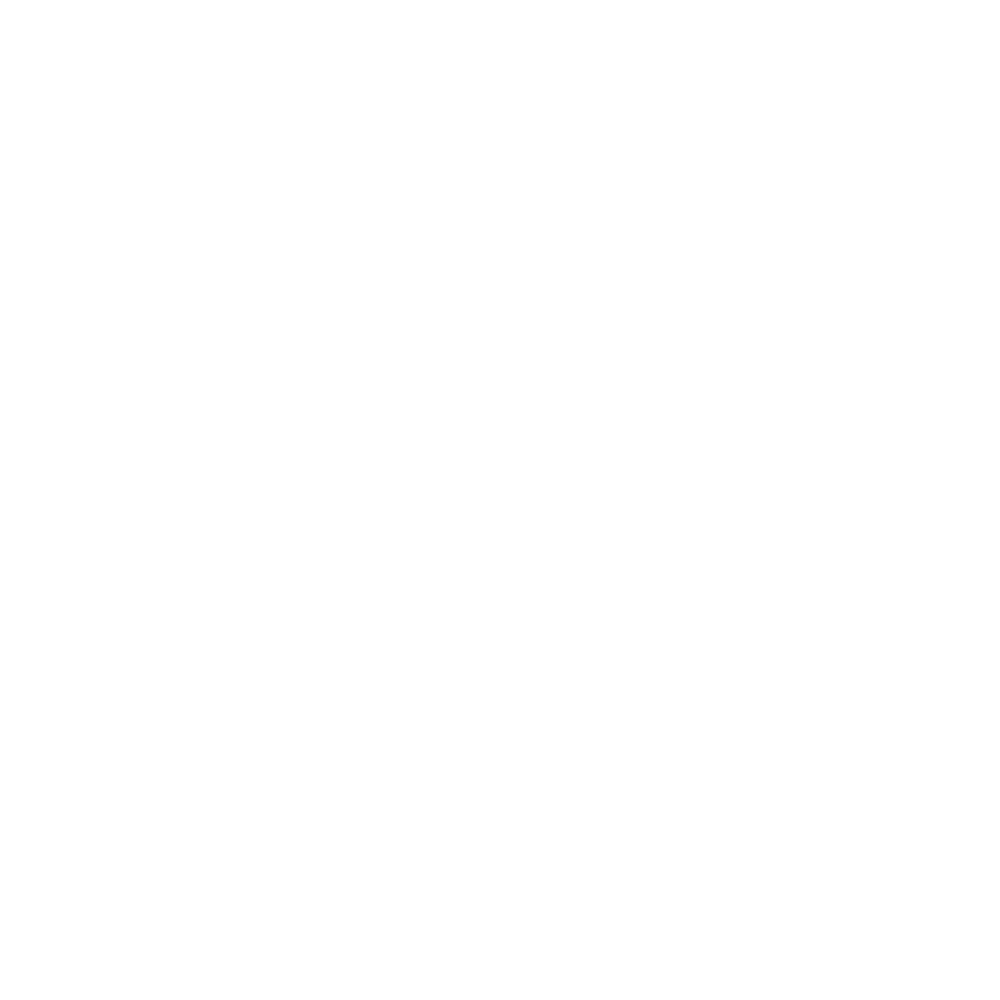

In [11]:
plt.close('all')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = keypts.T

ax.scatter(xs, ys, zs, s=3.)

set_=w_exp
for k, col in zip(range(len(set_)),itertools.cycle('rgbcmy')):
    deltas = set_[k].T
    dxs, dys, dzs = deltas
    ax.quiver(xs, ys, zs, dxs, dys, dzs, color=col)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


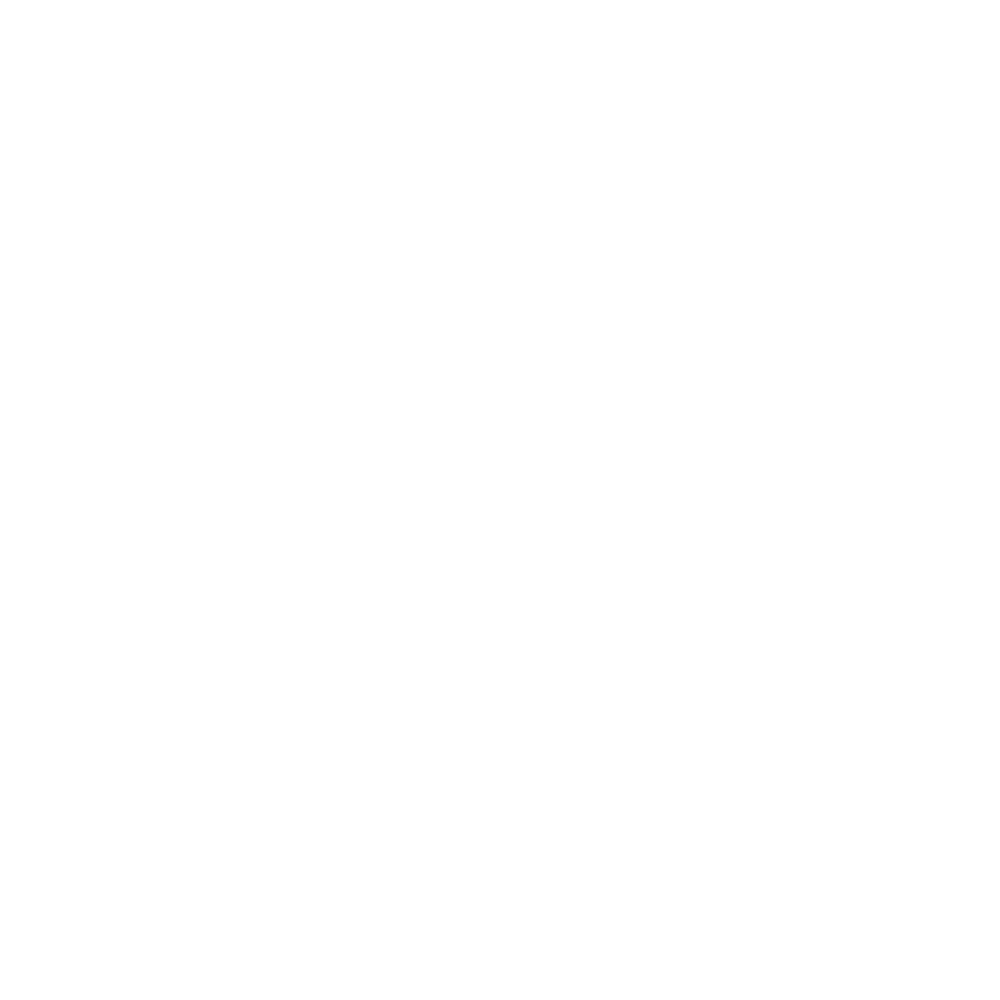

In [12]:
plt.close('all')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = keypts.T

ax.scatter(xs, ys, zs, s=3.)

set_=w_shp
for k, col in zip(range(len(set_)),itertools.cycle('rgbcmy')):
    deltas = set_[k].T
    dxs, dys, dzs = deltas
    ax.quiver(xs, ys, zs, dxs, dys, dzs, color=col)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [65]:
import torch
import neuralnets.modelcomponents

In [66]:
with torch.no_grad():
    basepts, deformvecs = neuralnets.modelcomponents.load_deformable_head_keypoints(3,7)

In [67]:
output = neuralnets.modelcomponents.PoseOutputStage()

In [68]:
with torch.no_grad():
    input_ = torch.zeros(1,7)
    input_[:,2] = 1.
    input_[:,3:] = torch.from_numpy(Rotation.identity().as_quat())
    coord, pose = output(input_)
coord, pose

(tensor([[0., 0., 1.]]), tensor([[0., 0., 0., 1.]]))

In [69]:
with torch.no_grad():
    kptweights = torch.zeros((1,10), dtype=torch.float32)
    kptweights[0,3] = -1 # Open mouth

    local_keypts = deformvecs[None,...] * kptweights[:,:,None,None]
    local_keypts = torch.sum(local_keypts, dim=1)
    local_keypts += basepts[None,...]

    global_keypts = output.headcenter_to_screen_3d(local_keypts)
    global_keypts = global_keypts.numpy()

In [70]:
global_keypts.shape

(1, 68, 3)

<IPython.core.display.Javascript object>


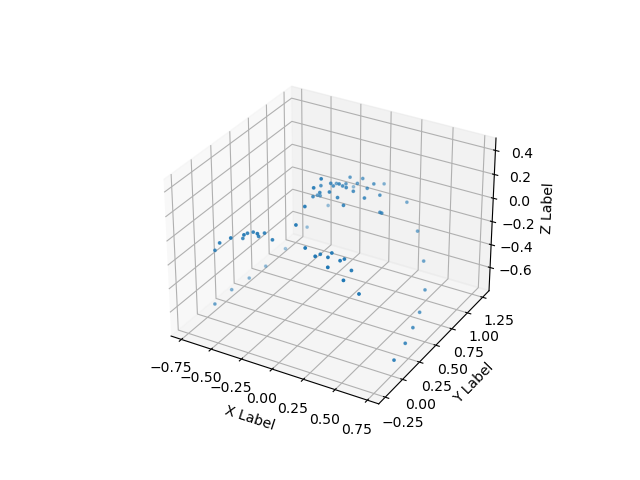

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = global_keypts[0].T

ax.scatter(xs, ys, zs, s=3.)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

Extra points for bounding box computation
-------------------------------------------------------------

In [77]:
from datasets.preprocessing import extended_key_points_for_bounding_box

<IPython.core.display.Javascript object>


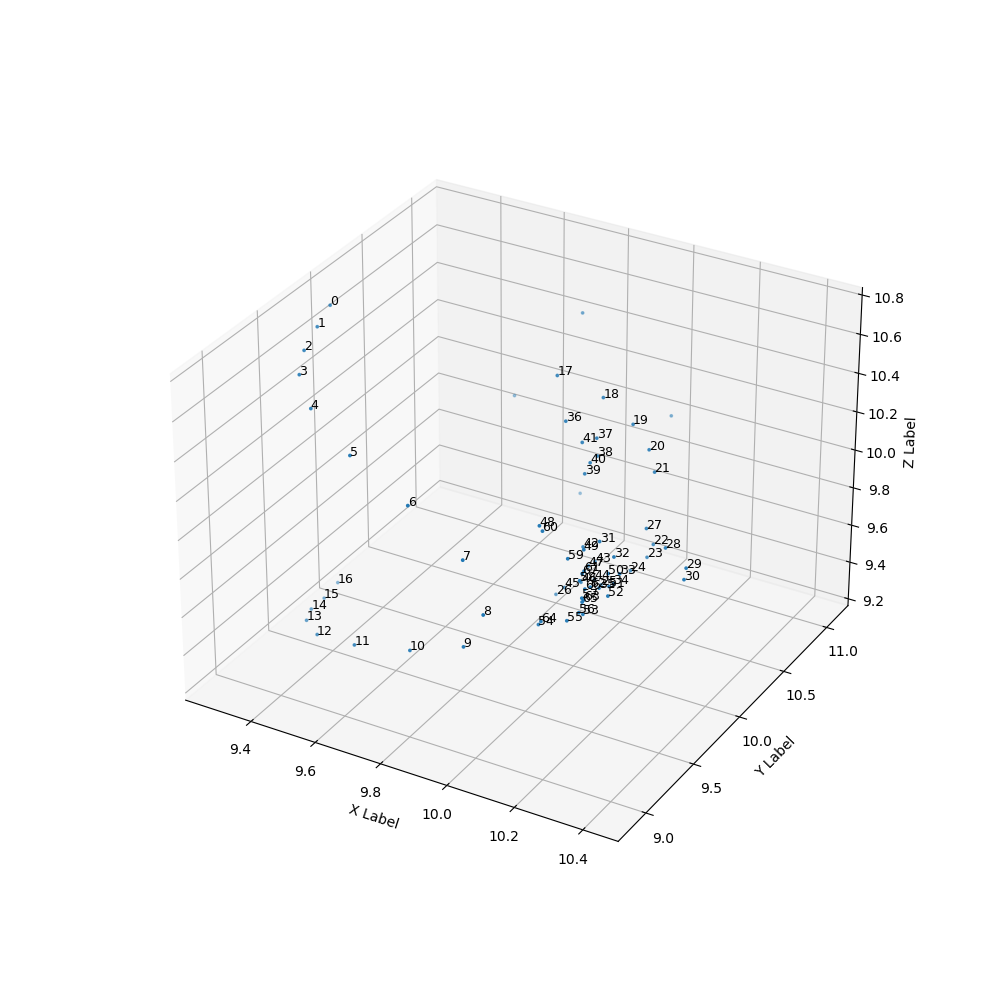

In [78]:
plt.close('all')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

shifted_keypts = keypts + 10.

extended_keypts = extended_key_points_for_bounding_box(shifted_keypts)

xs, ys, zs = extended_keypts.T

ax.scatter(xs, ys, zs, s=3.)

for i, p in enumerate(shifted_keypts):
    ax.text(p[0], p[1], p[2], s=str(i), size=9)
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()